# **IMPORTING NECESSARY LIBRARIES**

In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten, Dropout, BatchNormalization
from keras.models import Model
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import os

# **LOADING AND UNZIPPING THE DATASET**

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1ReLMPYgrLXAPhAlo2pd4atv2TZa0fvjM' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1ReLMPYgrLXAPhAlo2pd4atv2TZa0fvjM" -O data.zip && rm -rf /tmp/cookies.txt

--2020-12-04 19:33:11--  https://docs.google.com/uc?export=download&confirm=pWDX&id=1ReLMPYgrLXAPhAlo2pd4atv2TZa0fvjM
Resolving docs.google.com (docs.google.com)... 172.217.164.174, 2607:f8b0:4004:815::200e
Connecting to docs.google.com (docs.google.com)|172.217.164.174|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-04-84-docs.googleusercontent.com/docs/securesc/fao6voa32t7mla7p7kc9o9urvrf5k0o3/a112a9jbf9rqr2vr6rfr1okjeq8sna0m/1607110350000/14211000813324722452/11467399059447869350Z/1ReLMPYgrLXAPhAlo2pd4atv2TZa0fvjM?e=download [following]
--2020-12-04 19:33:11--  https://doc-04-84-docs.googleusercontent.com/docs/securesc/fao6voa32t7mla7p7kc9o9urvrf5k0o3/a112a9jbf9rqr2vr6rfr1okjeq8sna0m/1607110350000/14211000813324722452/11467399059447869350Z/1ReLMPYgrLXAPhAlo2pd4atv2TZa0fvjM?e=download
Resolving doc-04-84-docs.googleusercontent.com (doc-04-84-docs.googleusercontent.com)... 172.217.9.193, 2607:f8b0:4004:806::2001
Connecting to doc-

In [ ]:
!unzip '/content/data.zip'

Streaming output truncated to the last 5000 lines.
  inflating: split_dataset/train/bottles/img (676).jpg  
  inflating: split_dataset/train/bottles/img (677).jpg  
  inflating: split_dataset/train/bottles/img (678).jpg  
  inflating: split_dataset/train/bottles/img (679).jpg  
  inflating: split_dataset/train/bottles/img (68).jpg  
  inflating: split_dataset/train/bottles/img (680).jpg  
  inflating: split_dataset/train/bottles/img (681).jpg  
  inflating: split_dataset/train/bottles/img (682).jpg  
  inflating: split_dataset/train/bottles/img (683).jpg  
  inflating: split_dataset/train/bottles/img (684).jpg  
  inflating: split_dataset/train/bottles/img (685).jpg  
  inflating: split_dataset/train/bottles/img (686).jpg  
  inflating: split_dataset/train/bottles/img (687).jpg  
  inflating: split_dataset/train/bottles/img (688).jpg  
  inflating: split_dataset/train/bottles/img (689).jpg  
  inflating: split_dataset/train/bottles/img (69).jpg  
  inflating: split_dataset/train/bottle

# **SPECIFIYING PATHS TO DIRECTORY**

In [ ]:
from glob import glob
base_path = '/content/split_dataset'
folders = glob('/content/split_dataset/train/*')
print(folders)

['/content/split_dataset/train/boots', '/content/split_dataset/train/pistol_revolver', '/content/split_dataset/train/automatic_rifles', '/content/split_dataset/train/knives', '/content/split_dataset/train/syringes', '/content/split_dataset/train/band-aid', '/content/split_dataset/train/bottles', '/content/split_dataset/train/bullet_shells']


In [ ]:
IMAGE_SIZE = [224, 224]

train_path = '/content/split_dataset/train'
valid_path = '/content/split_dataset/validation'

# **PREPARING THE PRE-TRAINED ResNet101**

In [ ]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
x = Flatten()(vgg.output)
x = Dense(2048, activation='relu')(x)
x = Dropout(0.6)(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(2048, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.6)(x)
x = Dense(256, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

# **CREATING THE VGG16 MODEL**

In [ ]:
model_vgg = Model(inputs=vgg.input, outputs=prediction)
model_vgg.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [ ]:
opt = Adam(lr=0.0006)

model_vgg.compile(
  loss='categorical_crossentropy',
  optimizer= opt,
  metrics=['accuracy']
)

# **USING IMAGE AUGMENTATION**

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    rescale = 1./255,
    fill_mode = 'nearest')

validation_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('/content/split_dataset/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

validation_set = validation_datagen.flow_from_directory('/content/split_dataset/validation',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 6481 images belonging to 8 classes.
Found 1625 images belonging to 8 classes.


In [ ]:
history_vgg = model_vgg.fit_generator(
  training_set,
  validation_data=validation_set,
  epochs=50,
  verbose = 1,
  steps_per_epoch=150,
  validation_steps=32
  )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
 22/150 [===>..........................] - ETA: 54s - loss: 2.3264 - accuracy: 0.1307

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


150/150 [==============================] - 77s 516ms/step - loss: 2.0933 - accuracy: 0.2008 - val_loss: 1.7011 - val_accuracy: 0.3389
Epoch 2/50
150/150 [==============================] - 77s 516ms/step - loss: 1.4228 - accuracy: 0.4665 - val_loss: 0.9209 - val_accuracy: 0.6650
Epoch 3/50
150/150 [==============================] - 77s 512ms/step - loss: 1.0020 - accuracy: 0.6344 - val_loss: 0.8999 - val_accuracy: 0.7090
Epoch 4/50
150/150 [==============================] - 78s 520ms/step - loss: 0.7828 - accuracy: 0.7412 - val_loss: 0.4590 - val_accuracy: 0.8467
Epoch 5/50
150/150 [==============================] - 77s 511ms/step - loss: 0.7119 - accuracy: 0.7729 - val_loss: 0.3670 - val_accuracy: 0.8809
Epoch 6/50
150/150 [==============================] - 78s 517ms/step - loss: 0.6378 - accuracy: 0.7960 - val_loss: 0.3972 - val_accuracy: 0.8799
Epoch 7/50
150/150 [==============================] - 78s 519ms/step - loss: 0.5656 - accuracy: 0.8173 - val_loss: 0.3772 - val_accuracy: 0.8

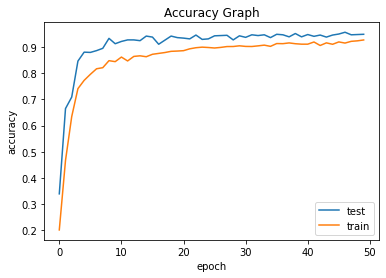

In [ ]:
plt.plot(history_vgg.history['val_accuracy'])
plt.plot(history_vgg.history['accuracy'])
plt.title('Accuracy Graph')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['test', 'train'], loc='lower right')
plt.show()

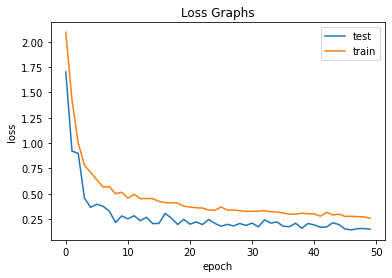

In [ ]:
plt.plot(history_vgg.history['val_loss'])
plt.plot(history_vgg.history['loss'])
plt.title('Loss Graphs')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['test', 'train'], loc='upper right')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
model_vgg.save('/content/gdrive/My Drive/Model/vgg16_new.h5')